# Exact diagonalization of QCA hamiltonians

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

# A few references

Bit twiddling in Python
+ https://wiki.python.org/moin/BitwiseOperators
+ https://wiki.python.org/moin/BitManipulation

Exact diagonalization
+ https://arxiv.org/abs/1101.3281
+ https://github.com/awietek/ed_basics

Quantum scars
+ https://arxiv.org/pdf/1711.03528.pdf
+ https://arxiv.org/pdf/1806.10933.pdf

# Bit-wise functions on a ring of L bits

In [2]:
# NOTE, L must be less than or equal to 32 throughout for s represented as a 32-bit int

def tobin(s, L):
    '''Expand the base-10 integer s into L bits of binary'''
    return [s >> y & 1 for y in range(L-1, -1, -1)]

def flip(s, j, L):
    '''Flip bit j of s'''
    return s ^ (1 << (L-1-j))


def invert(s, L):
    '''Invert all the bits of s'''
    return s ^ ((1<<L)-1)


def reverse(s, L):
    '''Reverse the bits of s'''
    result = 0
    for i in range(L):
        result <<= 1
        result |= s & 1
        s >>= 1
    return result


def cycleN(s, N, L):
    '''Cycle s to the left by N bits on a ring'''
    smax = (1<<L)-1
    l = (N+L)%L
    s1 = (s >> (L- l))
    s2 = ((s << l) & smax)
    return (s2 | s1)


def representative(s, L):
    '''
    Convert s to its representative under translational symmetry. 
    Also returns the number of translations connecting s to its representative.
    '''
    r = s
    l = 0
    for i in range(L):
        t = cycleN(s, i, L)
        if t < r: # Convention, use the lowest integer in a cycle as the representative
            r=t
            l=i
    return r, l


def neighbors(s, j, L):
    '''Read bits j-1 and j+1 of s'''
    hood = 0
    lb = (L-1 - (j-1)) % L
    rb = (L-1 - (j+1)) % L
    if s & (1 << lb):
        hood += 2
    if s & (1 << rb):
        hood += 1
    return hood


def Hj(s, j, R, L):
    '''Return QCA rule R applied to s at bit j'''
    if R & (1 << neighbors(s, j, L)):
        return flip(s, j, L)
    else:
        return None

# A few checks

In [3]:
# Check flip
L = 3
j = 1
for s in range(2**L):
    sprime = flip(s, j, L)
    print(s, tobin(s,L), sprime, tobin(sprime,L))

0 [0, 0, 0] 2 [0, 1, 0]
1 [0, 0, 1] 3 [0, 1, 1]
2 [0, 1, 0] 0 [0, 0, 0]
3 [0, 1, 1] 1 [0, 0, 1]
4 [1, 0, 0] 6 [1, 1, 0]
5 [1, 0, 1] 7 [1, 1, 1]
6 [1, 1, 0] 4 [1, 0, 0]
7 [1, 1, 1] 5 [1, 0, 1]


In [4]:
# Check invert
L =3
for s in range(2**L):
    sprime = invert(s,L)
    print(s, tobin(s,L), sprime, tobin(sprime,L))

0 [0, 0, 0] 7 [1, 1, 1]
1 [0, 0, 1] 6 [1, 1, 0]
2 [0, 1, 0] 5 [1, 0, 1]
3 [0, 1, 1] 4 [1, 0, 0]
4 [1, 0, 0] 3 [0, 1, 1]
5 [1, 0, 1] 2 [0, 1, 0]
6 [1, 1, 0] 1 [0, 0, 1]
7 [1, 1, 1] 0 [0, 0, 0]


In [5]:
# Check reverse
L =3
for s in range(2**L):
    sprime = reverse(s,L)
    print(s, tobin(s,L), sprime, tobin(sprime,L))

0 [0, 0, 0] 0 [0, 0, 0]
1 [0, 0, 1] 4 [1, 0, 0]
2 [0, 1, 0] 2 [0, 1, 0]
3 [0, 1, 1] 6 [1, 1, 0]
4 [1, 0, 0] 1 [0, 0, 1]
5 [1, 0, 1] 5 [1, 0, 1]
6 [1, 1, 0] 3 [0, 1, 1]
7 [1, 1, 1] 7 [1, 1, 1]


In [6]:
# Check cycle
L = 3
N = 1 # number of bits to cycle left, can be negative to cycle right
for s in range(2**L):
    sprime = cycleN(s, N, L)
    print(s, tobin(s,L), sprime, tobin(sprime,L))
    

0 [0, 0, 0] 0 [0, 0, 0]
1 [0, 0, 1] 2 [0, 1, 0]
2 [0, 1, 0] 4 [1, 0, 0]
3 [0, 1, 1] 6 [1, 1, 0]
4 [1, 0, 0] 1 [0, 0, 1]
5 [1, 0, 1] 3 [0, 1, 1]
6 [1, 1, 0] 5 [1, 0, 1]
7 [1, 1, 1] 7 [1, 1, 1]


In [7]:
# Check reresentative
L = 3
for s in range(2**L):
    sprime, l = representative(s, L)
    print(s, tobin(s, L), sprime, tobin(sprime, 3))

0 [0, 0, 0] 0 [0, 0, 0]
1 [0, 0, 1] 1 [0, 0, 1]
2 [0, 1, 0] 1 [0, 0, 1]
3 [0, 1, 1] 3 [0, 1, 1]
4 [1, 0, 0] 1 [0, 0, 1]
5 [1, 0, 1] 3 [0, 1, 1]
6 [1, 1, 0] 3 [0, 1, 1]
7 [1, 1, 1] 7 [1, 1, 1]


In [8]:
# Check neighbors
L = 3
j = 1
for s in range(2**L):
    sprime = neighbors(s, j, L)
    print(s, tobin(s,L), sprime, tobin(sprime, 2))

0 [0, 0, 0] 0 [0, 0]
1 [0, 0, 1] 1 [0, 1]
2 [0, 1, 0] 0 [0, 0]
3 [0, 1, 1] 1 [0, 1]
4 [1, 0, 0] 2 [1, 0]
5 [1, 0, 1] 3 [1, 1]
6 [1, 1, 0] 2 [1, 0]
7 [1, 1, 1] 3 [1, 1]


In [9]:
# Check Hj
L = 3
R = 1
j = 1
for s in range(2**L):
    sprime = Hj(s, j, R, L)
    if sprime is None:
        out = None
    else:
        out = tobin(sprime,L)
    print(s, tobin(s,L), sprime, out)

0 [0, 0, 0] 2 [0, 1, 0]
1 [0, 0, 1] None None
2 [0, 1, 0] 0 [0, 0, 0]
3 [0, 1, 1] None None
4 [1, 0, 0] None None
5 [1, 0, 1] None None
6 [1, 1, 0] None None
7 [1, 1, 1] None None


In [10]:
def k_basis(k, L):
    '''Get the k-momentum basis states for a ring of size L'''
    basis = []
    norms = [] 
    for s in range(2**L):
        r, l = representative(s, L)
        if s == r:
            amp = 0
            for i in range(L):
                sprime = cycleN(s, i, L)
                if sprime == s:
                    if i == 0:
                        R = L
                    else:
                        R = i
                    amp += np.exp(1j*2*np.pi*k/L*i)
            norm = np.sqrt(np.abs(amp))
            if norm > 1e-7:
                basis.append(s)
                norms.append(norm) 
    return basis, norms

# Hamiltonian construction

In [11]:
def Hblock(k, R, L):
    '''Construct the k-momentum block of the Rule-R QCA Hamiltonian'''
    basis, norms = k_basis(k, L)
    D = len(basis)
    H = np.zeros((D, D), dtype=complex)
    for ai, a in enumerate(basis):
        for j in range(L):
            bprime = Hj(a, j, R, L)
            if bprime is not None:
                b, lb = representative(bprime, L)
                
                #NOTE: Wehy the try-except? Shouldn't Hj keep s in the same momentum block?
                # Getting the right spectrum
                try:
                    bi = basis.index(b)
                except:
                    continue
                    
                val = norms[bi]/norms[ai] * np.exp(-1j* 2*np.pi * k * lb / L)
                H[ai, bi] += val
    return H
            

In [12]:
def Hblocks(L, R):
    '''Calculate all k-momentum blocks of the Rule-R QCA Hamiltonian'''
    Hs = []
    for k in range(L):
        Hs.append(Hblock(k, R, L))
    return Hs

In [13]:
def fullH(L, R):
    '''Calculate the full many-body hamiltonian in the computational basis with periodic boundary condidions.'''
    D = 2**L
    basis = range(D)
    H = np.zeros((D, D), dtype=complex)
    for a in basis:
        for j in range(L):
            b = Hj(a, j, R, L)
            if b is not None:
                H[a, b] += 1
    return H
            

In [14]:
# Check that we get the correct spectuem
L = 8
R = 1  # R = 0, 1, 2, ... 15
Hblocked = scipy.linalg.block_diag(*Hblocks(L, R))
H = fullH(L, R)

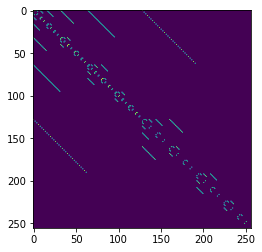

In [15]:
plt.imshow(np.abs(H))

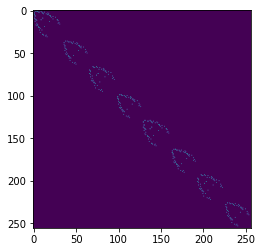

In [16]:
plt.imshow(np.abs(Hblocked))

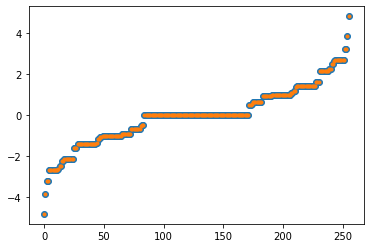

In [17]:
e1 = np.linalg.eigvalsh(H)
e2 = np.linalg.eigvalsh(Hblocked)
plt.plot(e1, marker='o', ls="none")
plt.plot(e2, marker=".", ls="none")


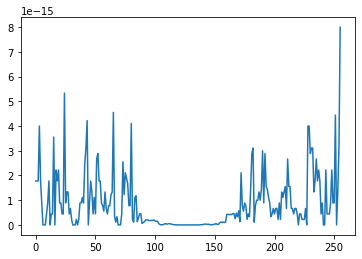

In [18]:
plt.plot(np.abs(e2-e1))

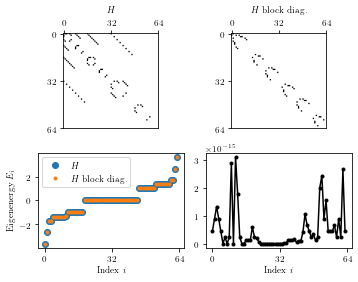

In [58]:
from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)


der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"

L = 6
R = 1
Hblocked = scipy.linalg.block_diag(*Hblocks(L, R))
H = fullH(L, R)
e1 = np.linalg.eigvalsh(H)
e2 = np.linalg.eigvalsh(Hblocked)


fig, axs = plt.subplots(2,2, figsize=(3.375*1.5, 4))
axs[0,0].imshow(np.abs(H)>0, cmap="Greys")
axs[0,0].set_title("$H$")
axs[0,0].set_xticks([0, 32, 64])
axs[0,0].set_yticks([0, 32, 64])
axs[0,0].xaxis.tick_top()


axs[0,1].imshow(np.abs(Hblocked)>0, cmap="Greys")
axs[0,1].set_title("$H$ block diag.")
axs[0,1].set_xticks([0, 32, 64])
axs[0,1].set_yticks([0, 32, 64])
axs[0,1].xaxis.tick_top()


axs[1,0].plot(e1, marker='o', ls="none", label="$H$")
axs[1,0].plot(e2, marker=".", ls="none", label="$H$ block diag.")
axs[1,0].legend()
axs[1,0].set_xticks([0, 32, 64])
axs[1,0].set_ylabel("Eigenenergy $E_i$")
axs[1,0].set_xlabel("Index $i$")

axs[1,1].plot(np.abs(e2-e1), c="k", marker=".")
axs[1,1].set_xticks([0, 32, 64])
axs[1,1].set_xlabel("Absolute difference")
axs[1,1].set_xlabel("Index $i$")

plt.tight_layout()
plt.savefig("figures/T_1-Kblocks.pdf", dpi=1000)


# Todo

+ Include reflection or spin-inversion symmetry
+ Build Hamiltonian in sparse matrix format (coo should be easy)
+ Extract energy eigenstates of the full system using the blocks
+ Quantum scars in QCA -- overlap of energy eigenstates with |Z2> = |01010...> vs eigenenergy
    + Prediction: All odd rule numbers will show scars. So will rule 8.
+ Quantum scars with other |Zn> states
+ ETH predictions
+ Gap ratio statistics

In [ ]:
Hblock |psi_1> |psi_2> |